In [1]:
import xarray
import pandas as pd
import numpy as np

import datetime

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
import matplotlib.dates as mdates

# Open h5 file here.

In [2]:
dat = '20191003'
base_date = pd.Timestamp('2019-10-03')


In [3]:
ds_nav = xarray.open_dataset(f'/home/svisaga/MUSICA_ANALYSES/WWW-AIR_1726704979598/CAMP2EX-HSRL2_P3B_{dat}_R0.h5', engine='h5netcdf', 
                             phony_dims='access', group='Nav_Data')

base_jday = ds_nav['Jday'][:,0].values[0]

# Calculate the difference in days from the base Julian Day
day_deltas = ds_nav['Jday'][:,0].values - base_jday

# Convert GPS times in hours to timedeltas
time_deltas = pd.to_timedelta(ds_nav['gps_time'][:,0].values, unit='h')

# Create datetime objects by adding the day deltas to the base date
dates = base_date + pd.to_timedelta(day_deltas, unit='D')

# Add the time deltas to the dates
date_times = dates + time_deltas

# Format the dates to YY-MM-DD
formatted_dates = date_times.strftime('%Y-%m-%d %H:%M:%S')


# Create a new xarray DataArray
ds_nav['Date'] = xarray.DataArray(
    formatted_dates,
    dims=["time"]
)



In [4]:
# Open the HDF5 file using the h5netcdf engine
ds = xarray.open_dataset(f'/home/svisaga/MUSICA_ANALYSES/WWW-AIR_1726704979598/CAMP2EX-HSRL2_P3B_{dat}_R0.h5', engine='h5netcdf', phony_dims='access', group='DataProducts')

In [5]:
ds

<xarray.Dataset>
Dimensions:                  (phony_dim_3: 1230, phony_dim_4: 450,
                              phony_dim_5: 1, phony_dim_7: 2, phony_dim_6: 1)
Dimensions without coordinates: phony_dim_3, phony_dim_4, phony_dim_5,
                                phony_dim_7, phony_dim_6
Data variables: (12/48)
    1064_aer_dep             (phony_dim_3, phony_dim_4) float64 ...
    1064_bsc                 (phony_dim_3, phony_dim_4) float64 ...
    1064_bsc_Sa              (phony_dim_3, phony_dim_4) float64 ...
    1064_bsc_cloud_screened  (phony_dim_3, phony_dim_4) float64 ...
    1064_bsr                 (phony_dim_3, phony_dim_4) float64 ...
    1064_bsr_cloud_screened  (phony_dim_3, phony_dim_4) float64 ...
    ...                       ...
    Angstrom_Spherical       (phony_dim_3, phony_dim_4) float64 ...
    Dust_Mixing_Ratio        (phony_dim_3, phony_dim_4) float64 ...
    WVD_1064_532             (phony_dim_3, phony_dim_4) float64 ...
    WVD_532_355              (phony_dim_3, phony_dim_4) float64 ...
    cloud_top_height         (phony_dim_3, phony_dim_5) float64 ...
    mask_low                 (phony_dim_3, phony_dim_4) float64 ...

In [6]:
variable_data = ds['532_ext']
variable_data

<xarray.DataArray '532_ext' (phony_dim_3: 1230, phony_dim_4: 450)>
[553500 values with dtype=float64]
Dimensions without coordinates: phony_dim_3, phony_dim_4
Attributes:
    Description:                      532 nm aerosol extinction coefficient
    Horizontal resolution (seconds):  60.0
    Vertical resolution (meters):     150.0
    cloud screen:                     active
    code_date:                        01-May-2017 10:16:32
    run_date:                         27-May-2020 03:19:18
    units:                            km^-1

In [22]:
dat = '20191003'
dat1 = '2019-10-03-03600'
dat2 = '2019-10-04-03600'
workdir = '/home/svisaga/MUSICA_ANALYSES/WWW-AIR_1726704979598/'
p3file = f'CAMP2Ex-mrg01-P3B-NC_merge_{dat}_R3.nc'
p3data_ds = xarray.open_dataset(workdir+p3file)

In [23]:
kk = 590
ee = 660
date_index = pd.DatetimeIndex(ds_nav['Date'][kk:ee].values)


In [24]:
variables = ['MLH']
selected_data = p3data_ds[variables]
p3data = selected_data.to_dataframe().reset_index()

print(p3data.dtypes)
p3data_ = p3data
p3data_.set_index('time', inplace=True)
p3data = p3data.reset_index()

p3data['time'] = pd.to_datetime(p3data['time'])



time    datetime64[ns]
MLH            float32
lat            float32
lon            float32
alt            float32
dtype: object


In [25]:
p3data_sub = p3data[(p3data['time'] > '2019-10-04 00:30:00') & (p3data['time'] < '2019-10-04 00:55:00')] 

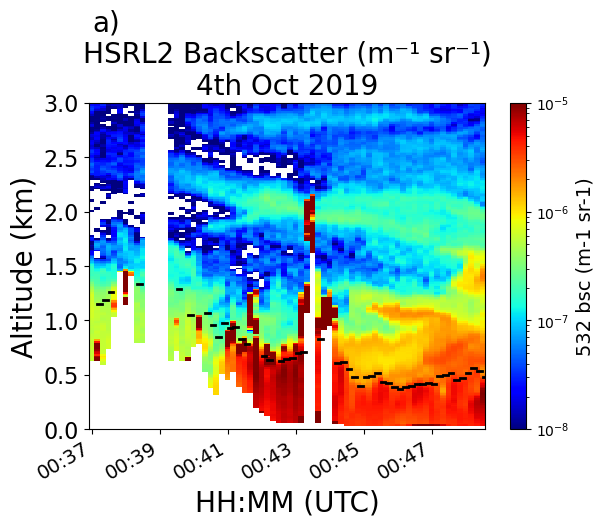

In [28]:

kk = 590
ee = 660
date_index = pd.DatetimeIndex(ds_nav['Date'][kk:ee].values)

fig, ax = plt.subplots()

ax.text(0.01, 1.2, f'a)', transform=ax.transAxes,
            fontsize=20,  va='bottom', ha='left')

c = ax.pcolormesh(date_index,ds['Altitude'][0,:].values/1000,ds['532_bsc'][kk:ee,:].T/1000,norm=mcolors.LogNorm(vmin=1E-8, vmax=1E-5),cmap='jet')

# Plot MLH on top
ax.plot(p3data_sub['time'], p3data_sub['MLH']/1000, color='black', linewidth=2, label='MLH')

plt.xticks(rotation=45,fontsize=14)

# Set major ticks every 30 minutes
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Optional: auto-format tick labels to avoid overlap
fig.autofmt_xdate()

plt.xlim()
plt.ylim(0,3)
plt.yticks(fontsize=16)

cbar = plt.colorbar(c,)
cbar.set_label('532 bsc (m-1 sr-1)', fontsize=14)
plt.title(f'HSRL2 Backscatter (m⁻¹ sr⁻¹)\n4th Oct 2019', fontsize=20)
plt.ylabel('Altitude (km)', fontsize=20)
plt.xlabel('HH:MM (UTC)',fontsize=20)
plt.savefig(f'img/Figure14a_AMSPaper.png',dpi=300, bbox_inches='tight')


In [7]:
ds['532_bsc']

<xarray.DataArray '532_bsc' (phony_dim_3: 1230, phony_dim_4: 450)>
[553500 values with dtype=float64]
Dimensions without coordinates: phony_dim_3, phony_dim_4
Attributes:
    Description:                      532 nm aerosol backscatter coefficient
    Horizontal resolution (seconds):  10.0
    Vertical resolution (meters):     15.0
    chi:                              1.0
    code_date:                        27-Jul-2017 16:15:18
    molecular depolarization:         0.0037
    run_date:                         27-May-2020 03:18:06
    units:                            km^-1sr^-1